## Grade: 6.0
### Comment: section 6.0 poor convergence but good explanation

# SLT-CE-3: Histogram Clustering

In this coding exercise, you will segment an image with histogram clustering (HC). You will implement two different methods: maximum a posterior probability (MAP) and deterministic annealing (DA) for predicting the cluster membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981 

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture05.pdf

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf, chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
#IMPORTED TO PAD THE BOUNDARIES OF THE ORIGINAL IMAGE WHILE COLLECTING LOCAL STATISTICS FROM THE IMAGE INSIDE A WINDOW
import cv2

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread
#IMPORTED METHOD TO PERFORM HUNGARIAN ALGORTIHM
from scipy.optimize import linear_sum_assignment
#BUILT IN METHODS IMPORTED TO EFFICIENTLY AND ERRORLESSLY CALCULATE KL DIVERGENCE IN DA IMPLEMENTATIOM
from scipy.stats import entropy
from sklearn.metrics import confusion_matrix 
#IMPORTED TO VISUALIZE THE CONFUSION MATRIX
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
#IMPORTED AS A BUILT IN IMPLEMENTATION OF KMEANS FOR COMPARISON WITH HC
from sklearn.cluster import KMeans

## Texture and corresponding label map
(This texture is used to fit your model.)

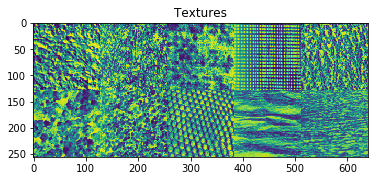

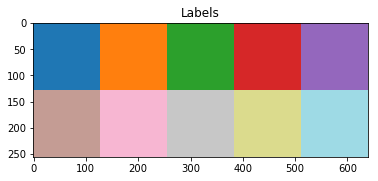

In [2]:
texture = imread("texture.png")
#8 bit image
patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
#print(texture.shape)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

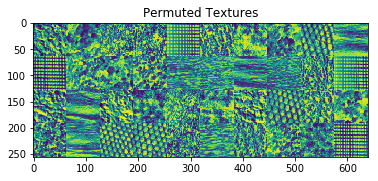

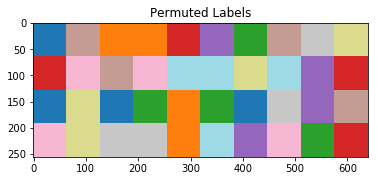

In [3]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both: maximum a posteriori probability estimation (MAP) and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> looks for the case of DA (using the notation of reference [1]).<br>
Hint: try to derive $\hat P(y|c)$ from $\hat P(c|x)$ and use the maximum entropy principle to find $\hat P(c|x)$.
</p>

The clustering model described in the paper [1] is a distributional clustering which investigates HC studied in the lectures. The paper again treats the objects $\mathcal{X}=\{x_1,x_2,...,x_N\}$ and set of possible features $\mathcal{Y}=\{y_1,y_2,...,y_N\}$ as dyadic measurement pairs $(x,y)\epsilon\mathcal{X}\times\mathcal{Y}$. Furthermore, the cooccurence matrix $\textbf(n)$ denotes the number of counts of these dyads, $n(x,y)$'s, assuming the role of an emprical joint distribution and summarizes our data, i.e. dyads. Moreover, the solutions are described by the cluster assignment function $C : x \mapsto \{c_1,...,c_k\}$. This model which is referred to as 'Asmyptotic CLusterin Model (ACM)' furthermore assumes the generative model in which first a data object is selected with probability $P(x)$, then assigned to a cluster via the cluster assignment function $c$ which is described by the features according to the probability law $P(y|c)$. Hence, the optimization parameters (from MAP-Bayesian perspective) $P(x)$ and $P(y|x)$ are sumarized in the vector $\theta$. Moreover, by the Markovian modelling of the data generation process, the model assumes the probability relation $P(x,y|c,\theta) = P(x)P(y|c(x))$. Additionally, assuming the independence of $\theta$ and $c$ in the prior and assuming a uniform prior on $\theta$, the posterior is derived as;

$P(c,\theta|\textbf{n}) \propto P(c){\prod_{x\epsilon\mathcal{X}}{ \prod_{y\epsilon\mathcal{Y}} {{P(x)P(y|c(x))}^{n(x,y)}}}}$

The MAP method naturally utilizes this posterior distribution and pursues the minimization of the posterior  of c and $\theta$. Equivalently, it defines the log posterior as,

$L(c,\theta;\textbf{n}) = \sum_{x\epsilon\mathcal{X}} {n(x)[\sum_{y\epsilon\mathcal{Y}} {P(y|x)logP(y|c(x)) + logP(x)}] + logP(c)} $

Then, further imposing the normalization constraint of the parameters in $\theta$ via Lagrangian optimization, the optimal optimization parameters are naturally obtained from the log posterior via differentiation as per the 1st order necessary condition, yielding;

$\hat{P}(x) = \frac{n(x)}{\sum_{x'\epsilon\mathcal{X}}{n(x')}}$

$\hat{P}(y|c) = \sum_{x:\hat{c}(x)=c}{\frac{n(x)}{\sum_{x':\hat{c}(x')=c}{n(x')}}}\hat{P}(y|x)$ where $\hat{P}(y|x)=n(y|x)$

$\hat{c}(x) = \arg\min_{a}\{{-\sum_{y\epsilon\mathcal{Y}} {\hat{P}(y|x)log\hat{P}(y|a)-logP({\hat{c}_a^x)})}}\}$  where ${\hat{c}_a^x}(x)=a$ and ${\hat{c}_a^x}(x')=\hat{c}(x)$ for $x\neq x'$ denoting the cluster assignments when the assingment of object $x$ is set to class $a$.

When we inspect the aobve equalities, we notice that $\hat{P}(x)$ is updated irrespective of the other parameters as one would naturally expect. Moreover, $\hat{P}(y|c)$ is found to be linear average of all emprical feature distributions given the objects thus genaralizing the centroid update formula of KMEANS. And finally, the optimal $\hat{c}(x)$ appears to be a variation of nearest neighbour rule, assigning each object to a cluster $a$ that minimizes the partial cost contribution ${-\sum_{y\epsilon\mathcal{Y}} {\hat{P}(y|x)log\hat{P}(y|a)-logP({\hat{c}_a^x)})}}$ which also appears in $L(c,\theta;\textbf{n})$ as well.

As a final remark, when a uniform prior on $P(c)$ is assumed for computational convenience, the computation of these parameters is performed via Alternating Mİnimization; first computing $\hat{c}(x)$ analogous to the nearest neighbour rule and then alternatingly computing $\hat{P}(y|c)$ in a greedy manner. the computation of $\hat{P}(x)$ is trivial.

In the DA approach, a maximum likelihood principle is pursued and as we did in the lectures, the minimization of the negative log-likelihood  is chosen as a cost function which naturally yields the KL Divergence as a distortion measure (between the estimated feature distributions given the cluster assignments relative to the emprical feaature distributions given tha objects). Thus the KL divergence measure can be summarized as;

$D_{KL}{[\hat{P}(.|x)||P(.|c(x))]} = \sum_{y}{\hat{P}(y|x)log(\frac{\hat{P}(y|x)}{P(y|c(x))}})$

and the associated resulting cost function;

$L(c,\theta;\textbf{n}) = \sum_{x\epsilon\mathcal{X}}{D_{KL}{[\hat{P}(.|x)||P(.|c(x))]}}$ which agrees with our derivations for HC in class.

In extension, following the maximum entropy principle in accordance with our DAC approach, we can find the Gibbs distr which yields maximally noncommital solutions of clustering assignments via the minimization of entropy of solutions given the dyads subject to an expected cost constraint. This is formulated as;

$\mathcal{L}(P(c|\theta),\lambda_1,\lambda_2)=H[P(c|\theta)]+\lambda_1(\mathbb{E}_{c|\theta}[L(c,\theta;\textbf{n})]-\mu)+\lambda_2(\sum_{c}{P(c|\theta)}-1)$

We notice that the above derivation is identical to that of the kmeans Gibbs Distribution except for the new adaptation of the cost function which is given as $-L(c,\theta;\textbf{n})$. Moreover, once again we observe that the distrortion measure is linear in $c$ as apparent from the definition of $D_{KL}{[\hat{P}(.|x)||P(.|c(x))]}$ above which allows us to factor out the resulting Gibbs Distribution as;

$P(c|\theta)=\prod_{x\epsilon\mathcal{X}}{P(c(x)=\alpha|\theta)}$

where $P(c(x)=\alpha|\theta)=\frac{e^{\frac{n(x)D_{KL}{[\hat{P}(.|x)||\hat{P}(.|\alpha)]}}{T}}}{\sum_{b=1}^{K}e^{\frac{-n(x)D_{KL}{[\hat{P}(.|x)||\hat{P}(.|c(x))]}}{T}}}$

Then, optimal prototypical distributions, $\hat{P}(y|c)$'s, can be obtained by Lagrangian Minimization of the entropy calculated according to the Gibbs Distribution and the normalization constraints of $\hat{P}(y|c)$ for all $c$ with respect to $\hat{P}(y=y_j|c=\beta)$'s;

$\frac{\partial{}}{\partial \hat{P}(y=y_j|c=\beta)}{H[P(c|\theta)]+\sum_{\alpha=1}^{K}{\lambda_\alpha[\sum_{y\epsilon\mathcal{Y}}{\hat{P}(y|c(x))-1]}}}=0$

Following this derivation, we perform mathematical steps almost identical to the derivation for optimal centroids in chapter 4 for Kmeans DA. Here, we exploit the fact that $H[P(c|\theta)]=logZ$ and apply the sum-trick formula as we have shown earlier that the chosen cost is linear in the assignments $c(x_i)$. From this derivation we finally obtain;

$\hat{P}(y=y_j|c=\beta)=\frac{\sum_{i\leq N}{\hat{P}(y=y_j|x_i)P(c(x_i)=\beta|\theta)}}{\lambda_\alpha}$ where $\lambda_\alpha$ clearly serves as a normalization constant.

Therefore, summing the nominator over $y\epsilon\mathcal{Y}$ to retrieve this normalization constant, we obtain the update formula for equation (5) which now becomes $\hat{P}(y=y_j|c=\beta)=\frac{\sum_{i=1}^{N}{\hat{P}(y=y_j|x_i)P(c(x_i)=\beta|\theta)}}{\sum_{i\leq N}{P(c(x_i)=\beta|\theta)}}$

We once again notice that, this update formula generalizes the kmeans case by averaging over the prototypical distributions instead of prototypical centroids which stems from our new convention of representing our data. So we notice that despite our modification of representation, our data inference principle is essentially the same but adapted to the probability simplex. 


In [4]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)

    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).

    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values(i.e. color features) found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """

    def __init__(self, n_clusters=10, n_bins=64, window_size=7, random_state=21, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins = n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        self.cluster_assignments = None
        self.interval = None
        self.centroids = None
        self.n_objects = None

        self.T = None  # Initialized in fit()
        self.T_min = 0.01  # Somethin small
        self.T_min_scaler = 10
        self.cooling_param = 0.95  # Emprically chosen
        self.sigma = 0.001
        self.cluster_probs = None
        self.p_y_given_x = None
        
        self.centroids_list = []
        
        # Add more parameters, if necessary.

    def fit(self, X):
        """Compute HC for input image X

        Compute centroids.

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            self
        """

        self.interval = 256 / self.n_bins  # For quantizing original image colors to given bins
        # print(interval)
        height = X.shape[0]
        width = X.shape[1]
        n_objects = X.shape[0] * X.shape[1]
        X_padded = cv2.copyMakeBorder(X, int((self.window_size - 1) / 2), int((self.window_size - 1) / 2),
                                      int((self.window_size - 1) / 2), int((self.window_size - 1) / 2),
                                      cv2.BORDER_REPLICATE)
        X_padded *= 255.0 / X_padded.max()  # Scale image to 0,255
        # print(X_padded)
        # plt.imshow(X_padded)
        np.random.seed(self.random_state)

        interval = self.interval
        n_x_y = np.zeros((n_objects, self.n_bins))  # 2D array of local color counts of 64 bins for each pixel site(object)
        value = int((self.window_size - 1) / 2)
        index = 0
        for i in range(value, height + value):
            for j in range(value, width + value):
                local_arr = X_padded[i - value:i + value + 1, j - value:j + value + 1]
                local_arr = np.floor_divide(local_arr, interval)
                # print((np.histogram(local_arr.flatten(), bins=np.arange(self.n_bins+1))))
                # print(local_arr)
                n_x_y[index, :] = (np.histogram(local_arr.flatten(), bins=np.arange(self.n_bins + 1)))[0]
                index = index + 1

        # print(len(n_x_y[-1,:]))

        n_x = np.sum(n_x_y, axis=1)

        # print(n_x)

        p_y_given_x = n_x_y / n_x[:, None]  # n_objects x n_bins, emprical distr.
        self.p_y_given_x = p_y_given_x.copy()

        # print(p_y_given_x[1,:])

        p_c = (1 / self.n_clusters) * np.ones(self.n_clusters)  # Uniform prior on clusters assumed

        c_x = np.zeros(n_objects)

        for i in range(n_objects):
            c_x[i] = np.random.choice(
                np.arange(self.n_clusters))  # Inıtıally choose cluster assignments uniformly for each pixel

        # print(np.unique(c_x))

        if self.estimation == "MAP":

            n_y_c = np.zeros((self.n_clusters, self.n_bins))  # MOVED HERE SINCE DIFFERENT INTIALIZAZATION FOR DA

            for cluster in range(self.n_clusters):
                n_y_c[cluster, :] = np.sum(n_x_y[c_x == cluster, :], axis=0)

            p_y_given_c = n_y_c / np.sum(n_y_c, axis=1)[:, None]  # Initialized

            # print(p_y_given_c)

            convergence = False

            decision_arr = np.zeros((n_objects, self.n_clusters))
            p_y_given_c_temp = np.zeros((self.n_clusters, self.n_bins))

            i = 0
            while True:#ALTERNATING MINIMIZATION

                # Update c(x), uniform prior P(c)

                for a in range(self.n_clusters):
                    p_y_given_c[a, :][p_y_given_c[a, :] == 0] = 10 ** (-300)  # AGAINST DIVISION ERRORS
                    decision_arr[:, a] = (-1.0) * np.sum(np.multiply(p_y_given_x, np.log2(p_y_given_c[a, :])), axis=1)
                # print(decision_arr)

                temp_c_x = np.argmin(decision_arr, axis=1)

                c_x_old = c_x.copy()
                c_x = temp_c_x.copy()
                # print('updated_c_x:',np.unique(c_x))

                # Update p_y_given_c

                for c in range(self.n_clusters):

                    clustered_object_counts = n_x[c_x == c].copy()
                    # print(clustered_object_counts.shape)

                    clustered_object_p_y_given_x = p_y_given_x[c_x == c, :].copy()
                    # print(clustered_object_p_y_given_x.shape)

                    nominator = np.sum(np.multiply(clustered_object_counts[:, None], clustered_object_p_y_given_x), axis=0)
                    # print(nominator)
                    denominator = np.sum(clustered_object_counts)

                    if (denominator == 0):
                        print('denominator is 0', c)

                    p_y_given_c_temp[c, :] = nominator / denominator

                p_y_given_c_old = p_y_given_c.copy()
                p_y_given_c = p_y_given_c_temp.copy()
                # print(np.sum(p_y_given_c,axis=1))

                if ((c_x == c_x_old).all() and np.allclose(p_y_given_c, p_y_given_c_old) == True):
                    break

                # print('iteration',i)
                i = i + 1

            self.centroids = p_y_given_c.copy()  # FITTING
            self.cluster_assignments = c_x.copy()


        elif self.estimation == "DA":
            
            indicator_1 = True
            indicator_2 = True
            indicator_3 = True
            indicator_4 = True
            indicator_5 = True

            sample_mean = (1.0 / n_objects) * np.sum(p_y_given_x, axis=0)  # Initially collapses to the emprical mean

            p_y_given_c = np.tile(sample_mean, (10,1))

            self.T = 55  # Something large

            np.random.seed(self.random_state)  # IMPORTANT!!!!

            self.centroids = p_y_given_c.copy()

            iteration = 0
            while self.T > self.T_min:  # EM STEP
                self.centroids_list.append(self.centroids)

                # print(self.effective_centers.shape)
                convergence = False
                counter = 0
                while (convergence == False):
                    # print(counter)
                    KL_distance = self.get_distance(p_y_given_x, self.centroids.copy())
                    #print(KL_distance)
                    self.cluster_probs = self._calculate_cluster_probs(KL_distance.copy(), n_x, self.T)

                    temp_matrix = np.multiply(np.tile(p_y_given_x, (1, self.centroids.shape[0])),
                                              np.repeat(self.cluster_probs, repeats=p_y_given_x.shape[1], axis=1))
                    # print(temp_matrix.shape)
                    temp_matrix_2 = np.sum(temp_matrix, axis=0)
                    # print(temp_matrix_2.shape)
                    centroids_new = temp_matrix_2.reshape((self.centroids.shape[0], p_y_given_x.shape[1]))
                    # print(y_new.shape)
                    centroids_old = self.centroids.copy()
                    for centroid_idx in range(self.centroids.shape[0]):
                        self.centroids[centroid_idx, :] = centroids_new.copy()[centroid_idx,
                                                          :]  # Update ith distinct centroid yo yt+1
                    convergence = np.allclose(centroids_new, centroids_old)  # Check convergence
                    # print(y_new)
                    counter = counter + 1
                    print('EM Updates:',counter)
                    
                    #if(counter > 100):#Force the EM update to end
                        #break
                        
                        
                        
                self.centroids = self.centroids + self.sigma * np.random.rand(self.centroids.shape[0],
                                                                              self.centroids.shape[1])
                row_sums = self.centroids.sum(axis=1)
                self.centroids = self.centroids / row_sums[:, np.newaxis]

                self.T = self.T * self.cooling_param
                print('iteration', iteration)
                iteration = iteration + 1
                print('tempurature', self.T)

        return self

    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            C (np.ndarray): Assignment map (height, width)
        """
        check_is_fitted(self, ["centroids"])

        # C = self.cluster_assignments.reshape(X.shape[0],X.shape[1])
        interval = 256 / self.n_bins  # For quantizing original image colors to given bins
        # print(interval)
        height = X.shape[0]
        width = X.shape[1]
        n_objects = X.shape[0] * X.shape[1]
        X_padded = cv2.copyMakeBorder(X, int((self.window_size - 1) / 2), int((self.window_size - 1) / 2),
                                          int((self.window_size - 1) / 2), int((self.window_size - 1) / 2),
                                          cv2.BORDER_REPLICATE)
        X_padded *= 255.0 / X_padded.max()  # Scale image to 0,255

        n_x_y = np.zeros(
            (n_objects, self.n_bins))  # 2D array of local color counts of 64 bins for each pixel site(object)
        value = int((self.window_size - 1) / 2)
        index = 0
        for i in range(value, height + value):
            for j in range(value, width + value):
                local_arr = X_padded[i - value:i + value + 1, j - value:j + value + 1]
                local_arr = np.floor_divide(local_arr, interval)
                # print((np.histogram(local_arr.flatten(), bins=np.arange(self.n_bins+1))))
                # print(local_arr)
                n_x_y[index, :] = (np.histogram(local_arr.flatten(), bins=np.arange(self.n_bins + 1)))[0]
                index = index + 1

        n_x = np.sum(n_x_y, axis=1)

        p_y_given_x = n_x_y / n_x[:, None]  # n_objects x n_bins, emprical distr.

        decision_arr = np.zeros((n_objects, self.n_clusters))

        centroids = self.centroids.copy()

        for a in range(self.n_clusters):
            centroids[a, :][centroids[a, :] == 0] = 10 ** -(300)  # AGAINST DIVISION ERRORS
            decision_arr[:, a] = (-1.0) * np.sum(np.multiply(p_y_given_x, np.log2(centroids[a, :])), axis=1)
            

        C = np.argmin(decision_arr, axis=1)
        
        #if(self.estimation == 'MAP'):
        C = C.reshape(X.shape[0], X.shape[1])
        
        if(self.estimation == 'DA'):
            distance_mat = self.get_distance(p_y_given_x, self.centroids)
            probs = self._calculate_cluster_probs(distance_mat, n_x, self.T_min)
            C_temp = np.argmax(probs, axis = 1)
            #C = np.repeat(C, 16, axis=0)
            C = C.reshape(X.shape[0], X.shape[1])

        return C

    def generate(self, C):
        """Generate a sample image X from a texture label map C.

        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).

        Args:
            C (np.ndarray): Input array with shape (height, width)

        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])

        X = np.zeros((C.shape[0] * C.shape[1]))
        i = 0
        for pixel in list(C.flatten().astype('int')):
            X[i] = self.interval * np.random.choice(np.arange(self.n_bins), 1, p=self.centroids[pixel, :])
            i = i + 1

        return X.reshape((C.shape[0], C.shape[1]))

    def get_distance(self, p_y_given_x, p_y_given_c):
        """Calculate the distance matrix between samples and codevectors
        based on the given metric

        Args:
            samples (np.ndarray): Samples array (n_samples, n_features)
            clusters (np.ndarray): Codebook (n_centroids, n_features)

        Returns:
            D (np.ndarray): Distances (n_samples, n_centroids)
        """

        dist_mat = np.zeros((p_y_given_x.shape[0], p_y_given_c.shape[0]))

        centroid_num = p_y_given_c.shape[0]
        sample_num = p_y_given_x.shape[0]
        #print(sample_num)
        #print(centroid_num)
        #dist_mat = np.zeros((sample_num, centroid_num))
        #dist_mat_check = dist_mat.copy()

        p_y_given_x_extended = np.tile(p_y_given_x, (centroid_num,1))

        p_y_given_c_extended = np.repeat(p_y_given_c, sample_num, axis=0)

        #reciprocal_p_y_given_c_extended = (np.reciprocal(p_y_given_c_extended))

        #dist_mat_temp = np.multiply(p_y_given_x_extended, reciprocal_p_y_given_c_extended)
        #dist_mat_temp[dist_mat_temp==0] = 10**(-300)
        #dist_mat_temp_2 = np.sum(np.multiply(np.log2(dist_mat_temp), p_y_given_x_extended), axis=1)

        #print(dist_mat_temp_2.shape)

        dist_mat_temp_2 = entropy(p_y_given_x_extended, p_y_given_c_extended, base=2, axis=1)
        dist_mat = np.transpose(dist_mat_temp_2.reshape(centroid_num, sample_num))

        #for i in range(centroid_num):
            #for j in range(sample_num):
                #p_y_given_x[j, :][p_y_given_x[j, :] == 0] = 10**(-300)
                #p_y_given_c[i, :][p_y_given_x[i, :] == 0] = 10 ** (-300)
                #dist_mat_check[j, i] = entropy(p_y_given_x[j, :], p_y_given_c[i, :], base=2)

        #df=pd.DataFrame(dist_mat)
        #df.to_csv('dist_mat.csv', index=False, header=None)

        #df = pd.DataFrame(dist_mat_check)
        #df.to_csv('dist_mat_check.csv', index=False, header=None)
        #print(np.allclose(dist_mat, dist_mat_check))

        return dist_mat

    def _calculate_cluster_probs(self, dist_mat, n_x, temperature):

        # TODO:
        nominator = np.exp(-dist_mat*n_x[:,np.newaxis] / temperature)
        # print(np.max(nominator))
        probs = (skl.preprocessing.normalize((nominator), norm='l1', axis=1))
        # probs = nominator / row_sums[:, np.newaxis]
        # probs = np.array(probs)

        # print(probs)
        # print(self.T)

        return probs

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [8]:

%%time
HC = HistogramClustering(n_bins=128, window_size = 9, random_state = 7)
HC.fit(texture)
check_is_fitted(HC, ["centroids"])


CPU times: user 1min 30s, sys: 25.4 s, total: 1min 56s
Wall time: 1min 22s


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [9]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

CPU times: user 10.5 s, sys: 768 ms, total: 11.3 s
Wall time: 10.6 s


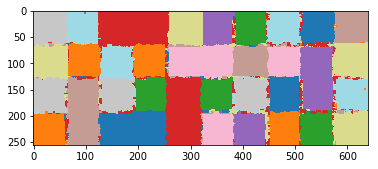

In [10]:
#print(predicted_perm_label_map[0:100,0:100])
plt.imshow(predicted_perm_label_map, cmap="tab20")
#print(np.unique(predicted_perm_label_map))

<p style="background-color:#adebad;">
    Plot the confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, to make them correspond to the true labels (see Hungarian algortihm to find the best match).
</p>

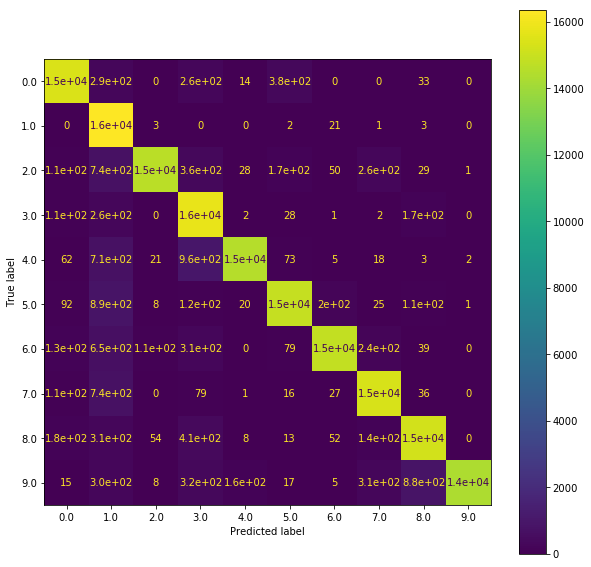

In [11]:
def hungarian_algorithm(predicted_perm_label_map, perm_label_map):
    
    #Cost_matrix

    cost_matrix = np.zeros( (len(np.unique(perm_label_map)), len(np.unique(perm_label_map))) )
    #print(12 in np.unique(predicted_perm_label_map))
    dummy_matrix_1 = predicted_perm_label_map.copy()
    dummy_matrix_2 = perm_label_map.copy()
    for prediction in list(np.unique(predicted_perm_label_map).astype('int')):
        for label in list(np.unique(perm_label_map).astype('int')):
            #print(prediction)
            #print(label)
            temp_matrix_1 = dummy_matrix_1.copy()
            temp_matrix_2 = dummy_matrix_2.copy()
            temp_matrix_1[temp_matrix_1 != prediction] = -1
            temp_matrix_1[temp_matrix_1 == prediction] = label
            temp_matrix_2[temp_matrix_2 != label] = -1

            cost_matrix[prediction, label] = np.count_nonzero(temp_matrix_1 != temp_matrix_2)

    #print(cost_matrix)


    # Hungarian Algorithm

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    #print(col_ind)
    #print(row_ind)

    counter = 0
    summation = np.zeros( (predicted_perm_label_map.shape[0], predicted_perm_label_map.shape[1])) 
    dummy = predicted_perm_label_map.copy()
    for i in list(row_ind):
        placeholder = dummy.copy()
        placeholder[placeholder != i] = -1#PROBLEM FOR i=0!!!!
        placeholder[placeholder == i] = col_ind[counter].copy()
        placeholder[placeholder != col_ind[counter]] = 0
        #print(np.unique(placeholder))
        summation = summation + placeholder
        counter = counter + 1

    predicted_perm_label_map_final = summation

    #print(np.unique(predicted_perm_label_map_final))
    #plt.figure()
    #plt.imshow(predicted_perm_label_map_final, cmap="tab20")
    #plt.figure()
    #plt.imshow(perm_label_map, cmap="tab20")
    
    return(predicted_perm_label_map_final)

confusion_matrix_HC = confusion_matrix(perm_label_map.flatten(), hungarian_algorithm(predicted_perm_label_map, perm_label_map).flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_HC, display_labels=np.unique(perm_label_map))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)




<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

n_bins: 16
window_size: 7
n_bins: 16
window_size: 9
n_bins: 16
window_size: 11
n_bins: 32
window_size: 7
n_bins: 32
window_size: 9
n_bins: 32
window_size: 11
n_bins: 64
window_size: 7
n_bins: 64
window_size: 9
n_bins: 64
window_size: 11
[[0.26083374 0.2748291  0.30175781]
 [0.31446533 0.37158203 0.3994873 ]
 [0.56304321 0.64677734 0.69917603]]


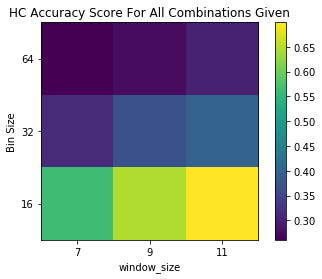

In [9]:
# 3x3 Matrix with accuracy scores of the different parameter combination

n_bins_options = [16, 32, 64]
window_size_options = [7, 9, 11]

i=0
j=0
score_matrix = np.zeros((3,3))
for n_bins in n_bins_options:
    for window_size in window_size_options:
        HC = HistogramClustering(n_bins=n_bins, window_size=window_size, random_state=13)
        HC.fit(texture)
        predicted_perm_label_map_itr = HC.predict(perm_texture)
        predicted_perm_label_map_itr_reassigned = hungarian_algorithm(predicted_perm_label_map_itr, perm_label_map)
        score_matrix[i,j] = np.count_nonzero(predicted_perm_label_map_itr_reassigned == perm_label_map)/(perm_label_map.shape[0]*perm_label_map.shape[1])
        j = j + 1
        #print('i:',i)
        #print('j:',j)
        print('n_bins:',n_bins)
        print('window_size:',window_size)
    i = i + 1
    j=0

fig, ax = plt.subplots(1,1)
img = ax.imshow(score_matrix, extent=[-1.5,1.5,-1.5,1.5])
ax.set_title('HC Accuracy Score For All Combinations Given')
ax.set_xlabel('window_size')
ax.set_ylabel('Bin Size')
x_label_list = ['7', '9', '11']
ax.set_xticks([-1.0,0.0,1.0])
ax.set_xticklabels(x_label_list)
y_label_list = ['16', '32', '64']
ax.set_yticks([-1.0,0.0,1.0])
ax.set_yticklabels(y_label_list)
fig.colorbar(img)

print(score_matrix)


    

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them accordingly.
    </p>

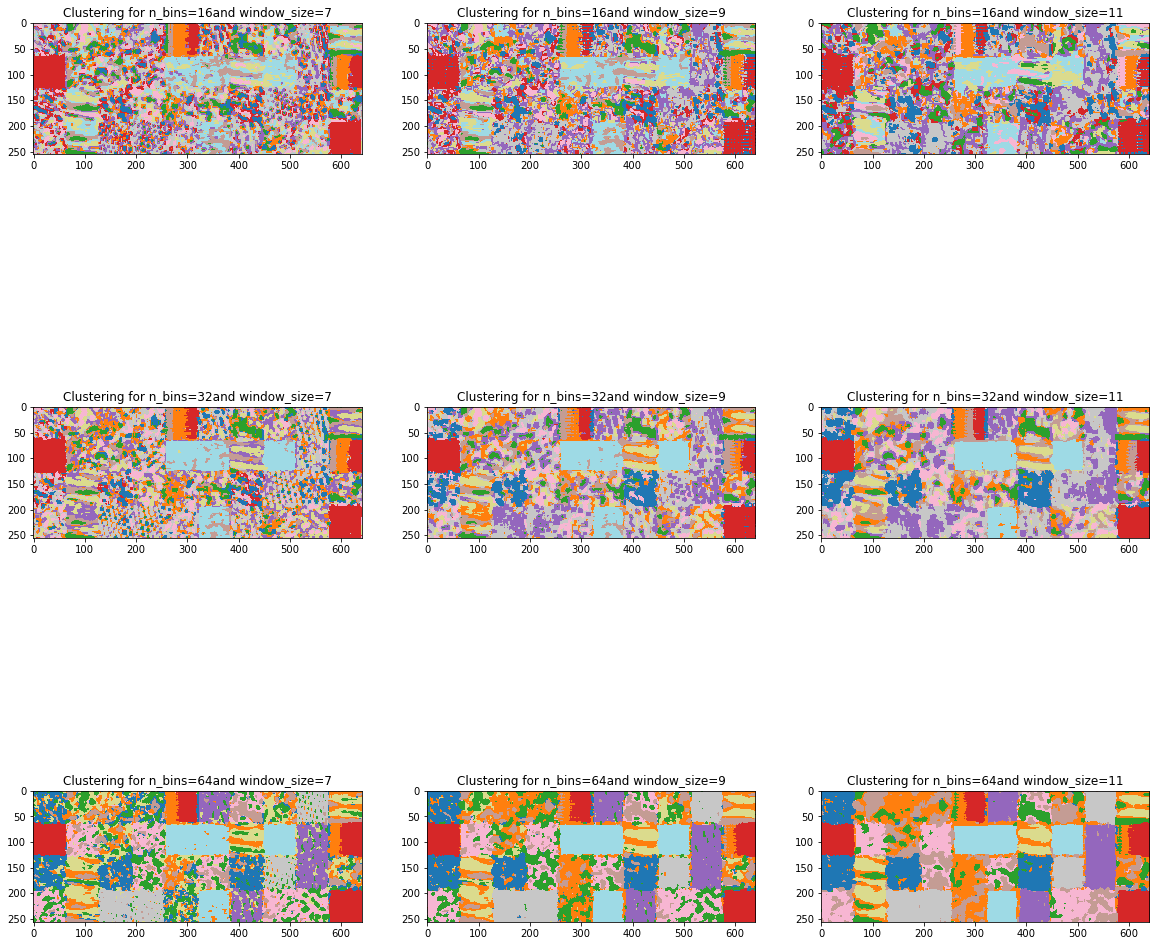

In [10]:
# Cluster predictions (9 plots arranged in a 3x3 grid)
fig, axs = plt.subplots(3,3, figsize=(20, 20))

n_bins_options = [16, 32, 64]
window_size_options = [7, 9, 11]

i=0
j=0

for n_bins in n_bins_options:
    for window_size in window_size_options:
        HC = HistogramClustering(n_bins=n_bins, window_size=window_size)
        HC.fit(texture)
        predicted_perm_label_map_itr = HC.predict(perm_texture)
        predicted_perm_label_map_itr_reassigned = hungarian_algorithm(predicted_perm_label_map_itr, perm_label_map)
        axs[i,j].set_title('Clustering for n_bins='+str(n_bins)+'and window_size='+str(window_size))
        axs[i,j].imshow(predicted_perm_label_map_itr_reassigned, cmap="tab20")
        j = j + 1
    i = i + 1
    j=0
        

As expected, with increasing n_bins or Window_size, the centroids are represented with higher precision and better summary statistics yielding better accuracies and clustering performances accordingly.

Text(0.5, 1.0, 'Original Texture')

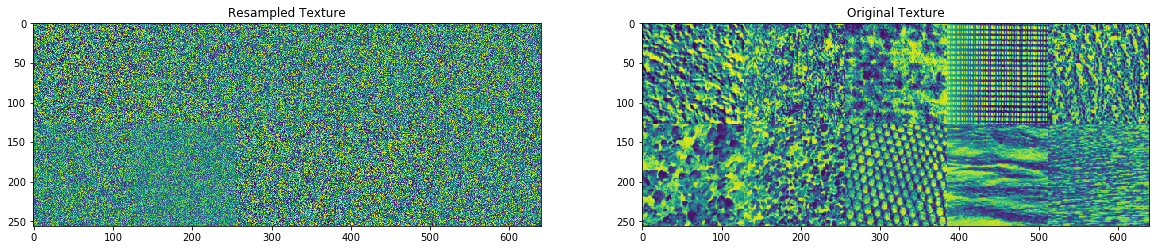

In [13]:
def hungarian_algorithm_ind(predicted_perm_label_map, perm_label_map):
    
    #Cost_matrix

    cost_matrix = np.zeros( (len(np.unique(perm_label_map)), len(np.unique(perm_label_map))) )
    #print(12 in np.unique(predicted_perm_label_map))
    dummy_matrix_1 = predicted_perm_label_map.copy()
    dummy_matrix_2 = perm_label_map.copy()
    for prediction in list(np.unique(predicted_perm_label_map).astype('int')):
        for label in list(np.unique(perm_label_map).astype('int')):
            #print(prediction)
            #print(label)
            temp_matrix_1 = dummy_matrix_1.copy()
            temp_matrix_2 = dummy_matrix_2.copy()
            temp_matrix_1[temp_matrix_1 != prediction] = -1
            temp_matrix_1[temp_matrix_1 == prediction] = label
            temp_matrix_2[temp_matrix_2 != label] = -1

            cost_matrix[prediction, label] = np.count_nonzero(temp_matrix_1 != temp_matrix_2)

    #print(cost_matrix)


    # Hungarian Algorithm

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    #print(col_ind)
    #print(row_ind)
    
    return[row_ind, col_ind]


C1 = np.ones(patch_shape) * 0#So we have to input the ground truth texture label map to generate()
X1 = HC.generate(C1)

HC_patch = HistogramClustering(n_bins=128, window_size = 9, random_state = 7)
HC_patch.fit(texture)
predicted_perm_label_map_patch = HC_patch.predict(perm_texture)

indices = hungarian_algorithm_ind(predicted_perm_label_map_patch, perm_label_map)
row_ind = indices[0]
col_ind = indices[1]

# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.
predicted_texture = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    if (patch == 0):
        C1 = np.ones(patch_shape) * row_ind[col_ind == patch]#SO THAT CLUSTERS ARE MATCHED AND WE OPERATE ON THE CORRESPONDİNG P(YGIVENC)
        X1 = HC_patch.generate(C1) 
        texture_itr = X1.copy()
    else:
        C = np.ones(patch_shape) * row_ind[col_ind == patch]#SO THAT CLUSTERS ARE MATCHED AND WE OPERATE ON THE CORRESPONDİNG P(YGIVENC)
        C = np.ones(patch_shape) * patch
        X = HC_patch.generate(C)
        texture_itr = np.append(texture_itr, X, axis=1)
        
sub_matrix_1, sub_matrix_2 = np.split(texture_itr, 2, axis=1)

predicted_texture = np.append(sub_matrix_1, sub_matrix_2, axis=0)

fig, ax = plt.subplots(1,2, figsize = (20,20))
ax[0].imshow(predicted_texture)
ax[0].set_title('Resampled Texture')
ax[1].imshow(texture)
ax[1].set_title('Original Texture')

    

# Generated texture plot

Here, we observe (especially for larger n_bins and window size when the clustering is more precise), the algorithm indeed learns the color feature distributions for each texture and we get the above prediction when we resample randomly for each texture class from the associated $p(y|c)$. We notice that, as a characteristic of HC, the frequency content of the textures are not kept and only the distributional qualities are kept, hence giving the impression of a noisy resampling. However, since the color content of all textures and their distributions are somewhat similar and since we only have one color channel, the resampled local color levels are also quite similar among each texture class. Therefore, the resampled texture cannot be very imformative about the segments due to this inherent color similarity of the textures.

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

(256, 640)


Text(0.5, 1.0, 'Label Map Prediction by HC')

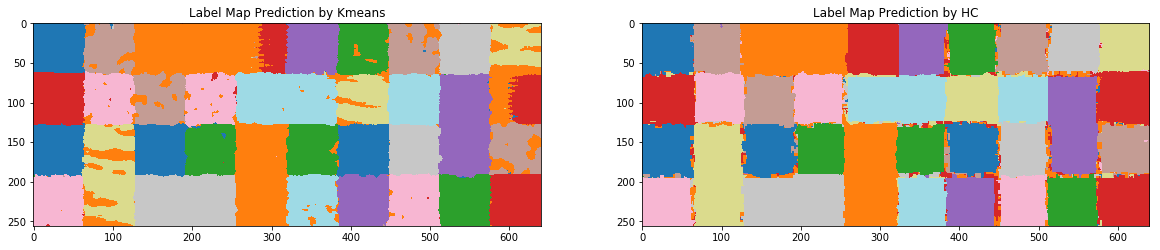

In [15]:
# Predicted label map for k-means
def convert_to_histogram(X):
    interval = 2  # For quantizing original image colors to given bins
    # print(interval)
    height = X.shape[0]
    width = X.shape[1]
    n_objects = X.shape[0] * X.shape[1]
    X_padded = cv2.copyMakeBorder(X, int((9 - 1) / 2), int((9 - 1) / 2),
                                  int((9 - 1) / 2), int((9 - 1) / 2),
                                  cv2.BORDER_REPLICATE)
    X_padded *= 255.0 / X_padded.max()  # Scale image to 0,255
    # print(X_padded)
    # plt.imshow(X_padded)
    np.random.seed(7)


    n_x_y = np.zeros(
        (n_objects, 128))  # 2D array of local color counts of 64 bins for each pixel site(object)
    value = int((9 - 1) / 2)
    index = 0
    for i in range(value, height + value):
        for j in range(value, width + value):
            local_arr = X_padded[i - value:i + value + 1, j - value:j + value + 1]
            local_arr = np.floor_divide(local_arr, interval)
            # print((np.histogram(local_arr.flatten(), bins=np.arange(self.n_bins+1))))
            # print(local_arr)
            n_x_y[index, :] = (np.histogram(local_arr.flatten(), bins=np.arange(128 + 1)))[0]
            index = index + 1

    # print(len(n_x_y[-1,:]))

    n_x = np.sum(n_x_y, axis=1)

    # print(n_x)

    p_y_given_x = n_x_y / n_x[:, None]  # n_objects x n_bins, emprical distr.

    return p_y_given_x

# Predicted label map for k-means
texture_kmeans = convert_to_histogram(texture)
perm_texture_kmeans = convert_to_histogram(perm_texture)


kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(texture_kmeans)
kmeans_label_map = kmeans.predict(perm_texture_kmeans).reshape(perm_texture.shape[0],perm_texture.shape[1])
print(kmeans_label_map.shape)
# plt.imshow(kmeans_label_map, cmap="tab20")
kmeans_label_map_optimal = hungarian_algorithm(kmeans_label_map, perm_label_map)

#FOR HC
HC_comparison = HistogramClustering(window_size=9, n_bins=128, random_state = 7)
HC_comparison.fit(texture)
predicted_perm_label_map_comparison = hungarian_algorithm(HC_comparison.predict(perm_texture), perm_label_map)


fig, ax = plt.subplots(1,2, figsize = (20,20))
ax[0].imshow(kmeans_label_map_optimal, cmap="tab20")
ax[0].set_title('Label Map Prediction by Kmeans')

# Predicted label map for HC
ax[1].imshow(hungarian_algorithm(predicted_perm_label_map_comparison, perm_label_map), cmap="tab20")
ax[1].set_title('Label Map Prediction by HC')

In this implementation, we see that KMeans, which would normally fail to cluster the texture correctly on the euclidian space, performs decently when clustering on the probability simplex using the histogram representation of the data as euclidian vectors. This property which stems from the decoupling of the data representation and inference principle in fact allows us to utilize kmeans on this scenario. Nevertheless, we observe that HC, when trained with the same hyperparameters outperforms kmeans as expected since it is a clustering principal specialized for such segmentation tasks. We also note that, although normally the performance of HC relative to kmeans would be substantially superior, in this setting where textures have similar and almost uniform color distributions kmeans can also imitate HC to a certain degree.

<ul style="background-color:#adebad;">
    <li>
        Plot and compare the confusion matrices for both, k-means, and HC.
    </li>
</ul>

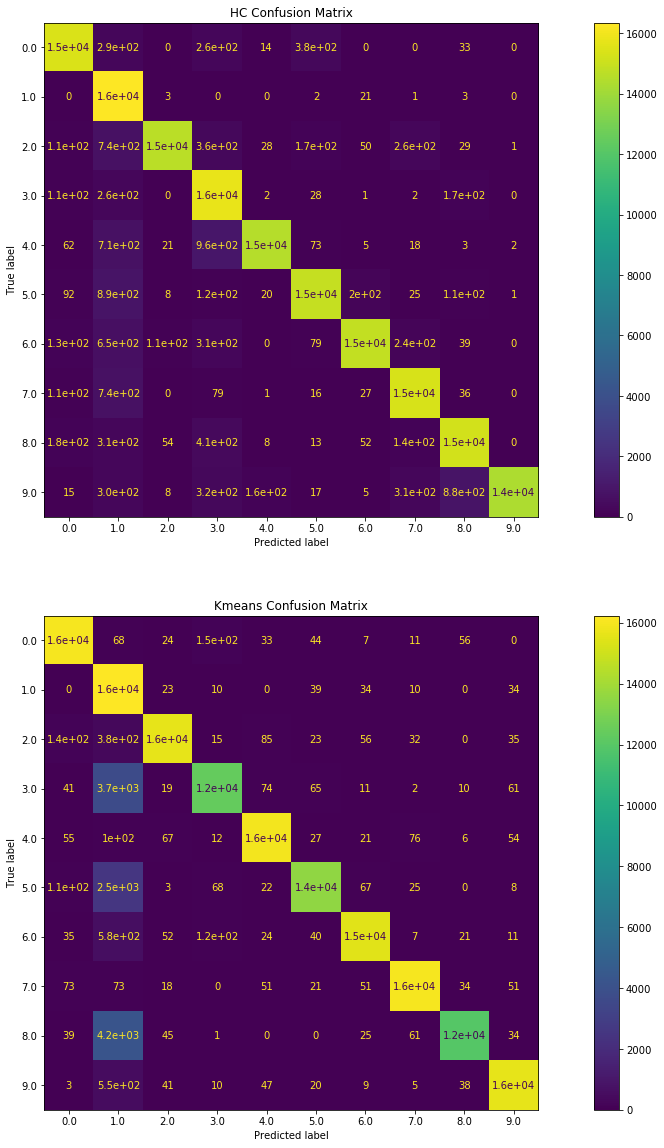

In [16]:
# Confusion matrices
fig, ax = plt.subplots(2,1,figsize=(20, 20))
ax[0].set_title('HC Confusion Matrix')
ax[1].set_title('Kmeans Confusion Matrix')

confusion_matrix_HC = confusion_matrix(perm_label_map.flatten(),predicted_perm_label_map_comparison.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_HC, display_labels=np.unique(perm_label_map))
disp.plot(ax=ax[0])

confusion_matrix_kmeans = confusion_matrix(perm_label_map.flatten(), kmeans_label_map_optimal.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_kmeans, display_labels=np.unique(perm_label_map))
disp.plot(ax=ax[1])

In compliance with the above discussion, the confusion matrix performance of HC is slightly superior to that of Kmeans algorithm since HC is a more sophisticated algorithm specialized for segmentation tasks.

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

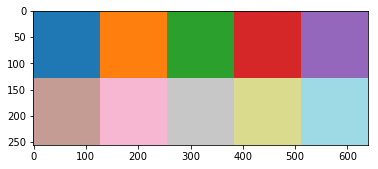

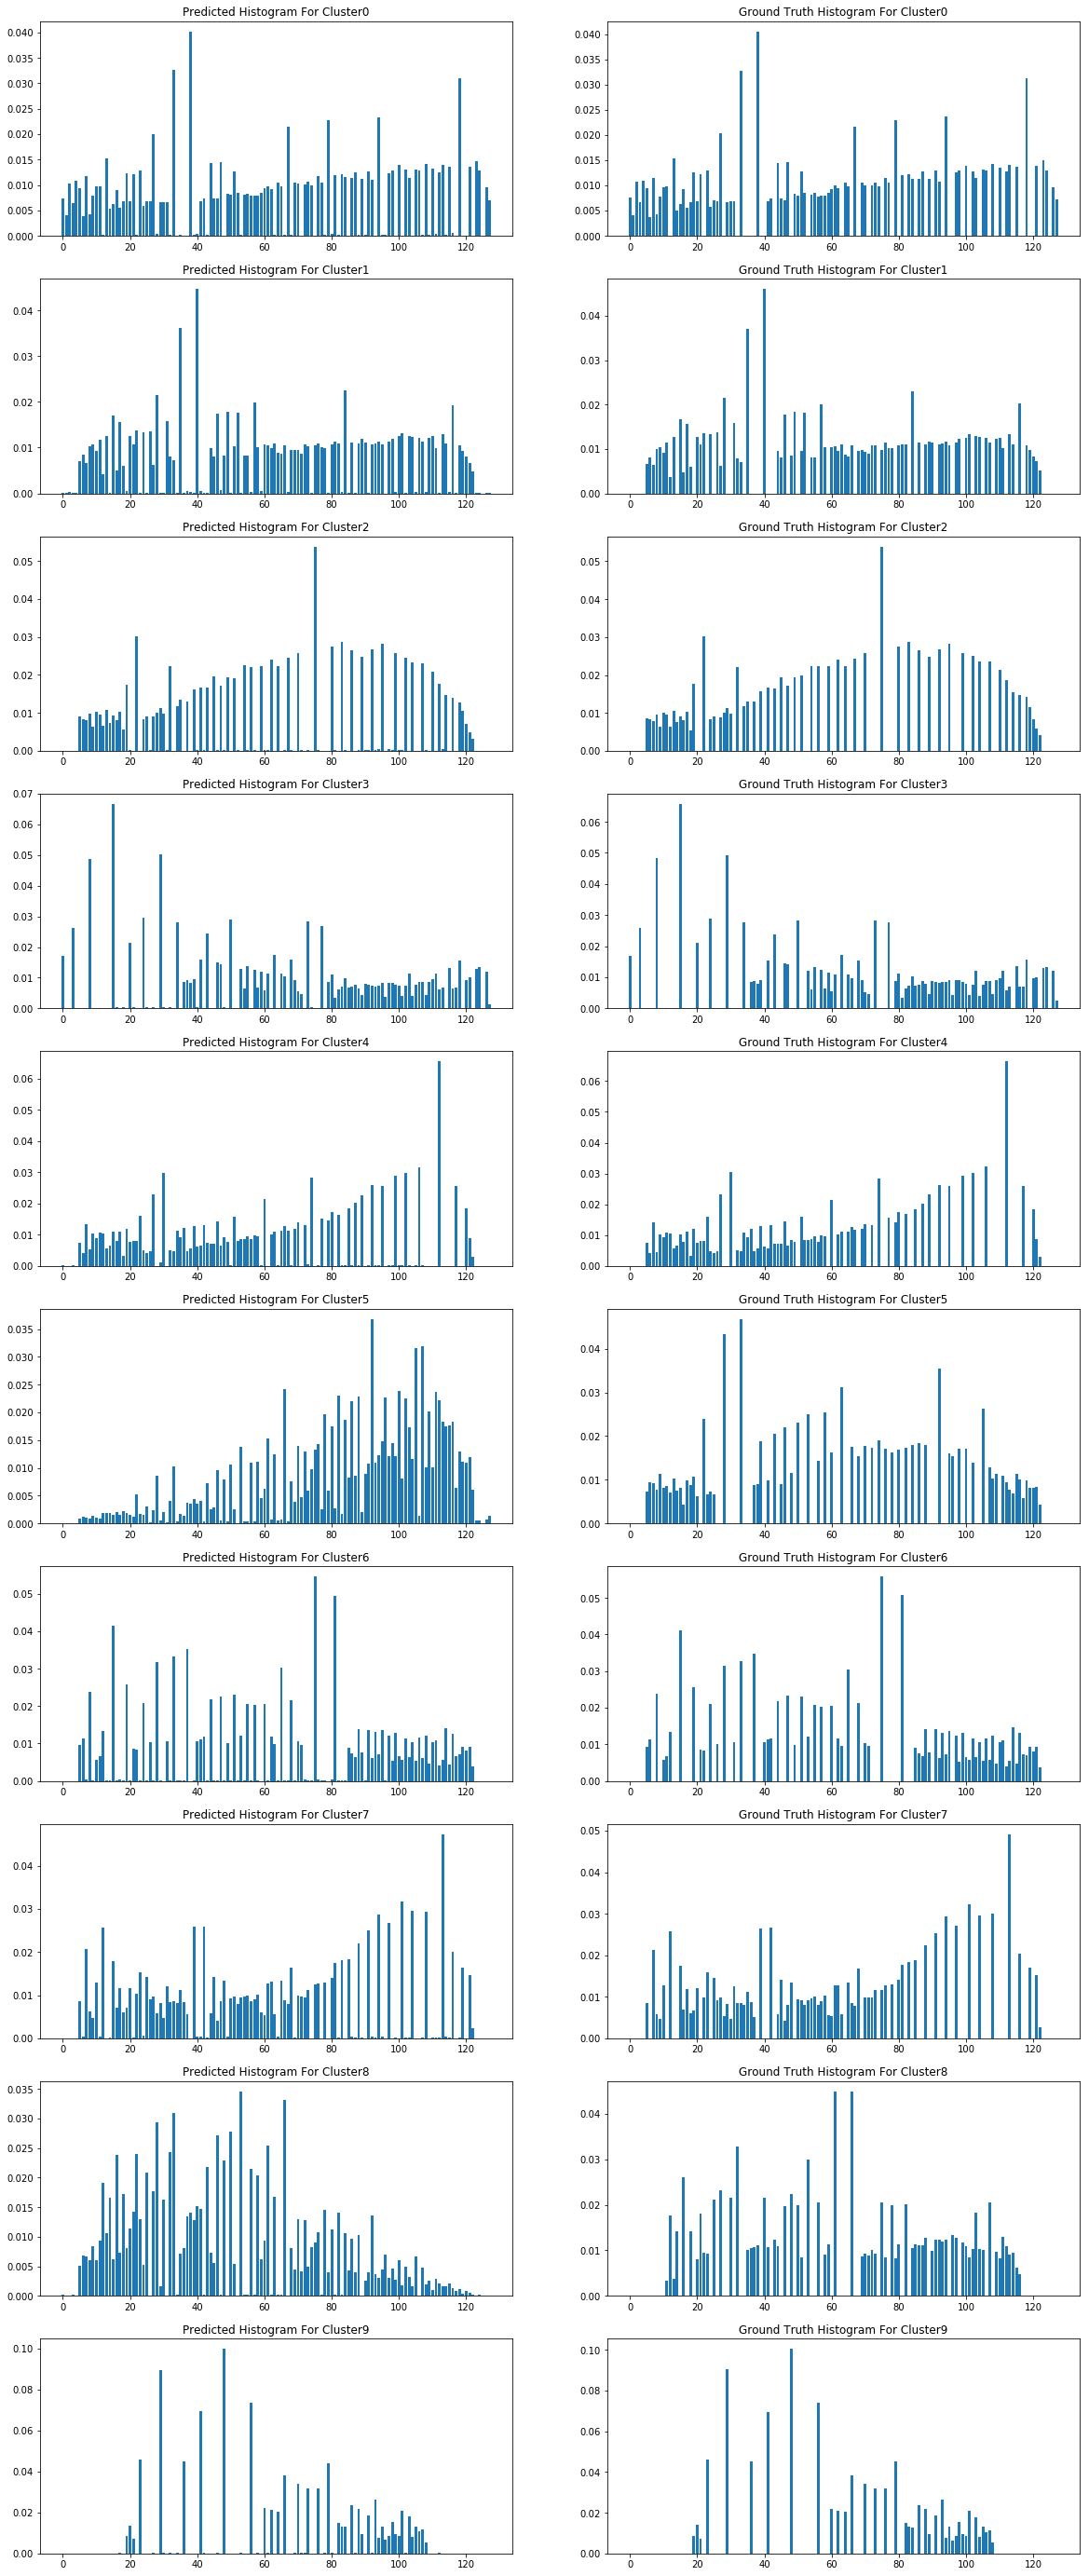

In [17]:
# Histograms
HC_hist = HistogramClustering(n_bins=128, window_size=9, random_state = 21)
HC_hist.fit(texture)
p_y_c = HC_hist.centroids.copy()


temp_texture = texture.copy()
temp_texture *= 255.0/temp_texture.max()
temp_texture = temp_texture // HC_hist.interval
#print(label_map.shape)

plt.imshow(label_map, cmap='tab20')

ground_truth_histograms = np.zeros((p_y_c.shape[0],p_y_c.shape[1]))

for assignment in list(np.unique(label_map).astype('int')):
    assigned_pixels = temp_texture[label_map == assignment].reshape(patch_shape)
    #print('found indices:',temp_texture[label_map == assignment].reshape(patch_shape))
    #print('target indices:',temp_texture[0:128,0:128].reshape(patch_shape))
    #if(assignment == 0):
        #print((assigned_pixels == temp_texture[0:128,0:128]))
    ground_truth_histograms[assignment,:] = (np.histogram(assigned_pixels.flatten(), bins=np.arange(HC_hist.n_bins+1), density=True))[0]

#print(ground_truth_histograms.shape)
#print(p_y_c.shape)

indices = hungarian_algorithm_ind(HC_hist.predict(texture), label_map)
row_ind = indices[0]
col_ind = indices[1]
#print(row_ind)
#print(col_ind)

fig, ax = plt.subplots(10,2, figsize=(20, 50))

for cluster in list(np.unique(label_map).astype('int')):
    ax[cluster,0].set_title('Predicted Histogram For Cluster'+str(cluster))
    ax[cluster,0].bar(np.arange(HC_hist.n_bins),p_y_c[int(row_ind[col_ind == cluster]),:])#So that clusters are matched and thus the histograms are matching
    ax[cluster,1].set_title('Ground Truth Histogram For Cluster'+str(cluster))
    ax[cluster,1].bar(np.arange(HC_hist.n_bins),ground_truth_histograms[cluster,:])

Here, we observe that HC fairly estiamtes the color histograms of all 10 features. For the default hyperparameters, while the predicted histograms are very similar to the original histograms for certain clusters, for some cases, the modes of the distributions in particular are similar. However, in certain cases, the we observe that the estimated histograms haven't converged to the actual target histograms to a sufficent degree yet. This is also anticipated as we didn't observe a near perfect clustering for HC in the previous parts when n_bins = 64 and window_size = 7. On the other hand, if we either increase n_bins or window_size as above, we observe that the clustering performance naturally increases and therefore, the estimated histograms(i.e centroids on the probability simplex) become almost identical to the actual histograms accordingly.

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


EM Updates: 1
EM Updates: 2
iteration 0
tempurature 52.25
EM Updates: 1
EM Updates: 2
iteration 1
tempurature 49.637499999999996
EM Updates: 1
EM Updates: 2
iteration 2
tempurature 47.15562499999999
EM Updates: 1
EM Updates: 2
iteration 3
tempurature 44.79784374999999
EM Updates: 1
EM Updates: 2
iteration 4
tempurature 42.55795156249999
EM Updates: 1
EM Updates: 2
iteration 5
tempurature 40.430053984374986
EM Updates: 1
EM Updates: 2
iteration 6
tempurature 38.408551285156236
EM Updates: 1
EM Updates: 2
iteration 7
tempurature 36.48812372089842
EM Updates: 1
EM Updates: 2
iteration 8
tempurature 34.6637175348535
EM Updates: 1
EM Updates: 2
iteration 9
tempurature 32.93053165811082
EM Updates: 1
EM Updates: 2
iteration 10
tempurature 31.28400507520528
EM Updates: 1
EM Updates: 2
iteration 11
tempurature 29.719804821445013
EM Updates: 1
EM Updates: 2
iteration 12
tempurature 28.233814580372762
EM Updates: 1
EM Updates: 2
iteration 13
tempurature 26.82212385135412
EM Updates: 1
EM Updates

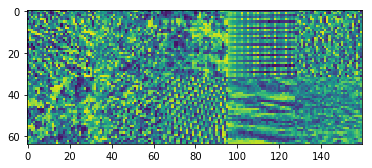

In [9]:
%%time
#texture_downsampled = np.resize(texture, ( int(texture.shape[0]/4), int(texture.shape[1]/4) ) )
texture_downsampled = rescale(texture, 0.25, anti_aliasing=False)
plt.imshow(texture_downsampled)
HC = HistogramClustering(estimation="DA", n_bins=32, window_size=13)
HC.fit(texture)
check_is_fitted(HC, ["centroids"])


<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. Describe what you observe.
        </li>
    </ul>

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0


IndexError: index 8 is out of bounds for axis 0 with size 8

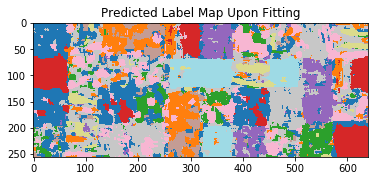

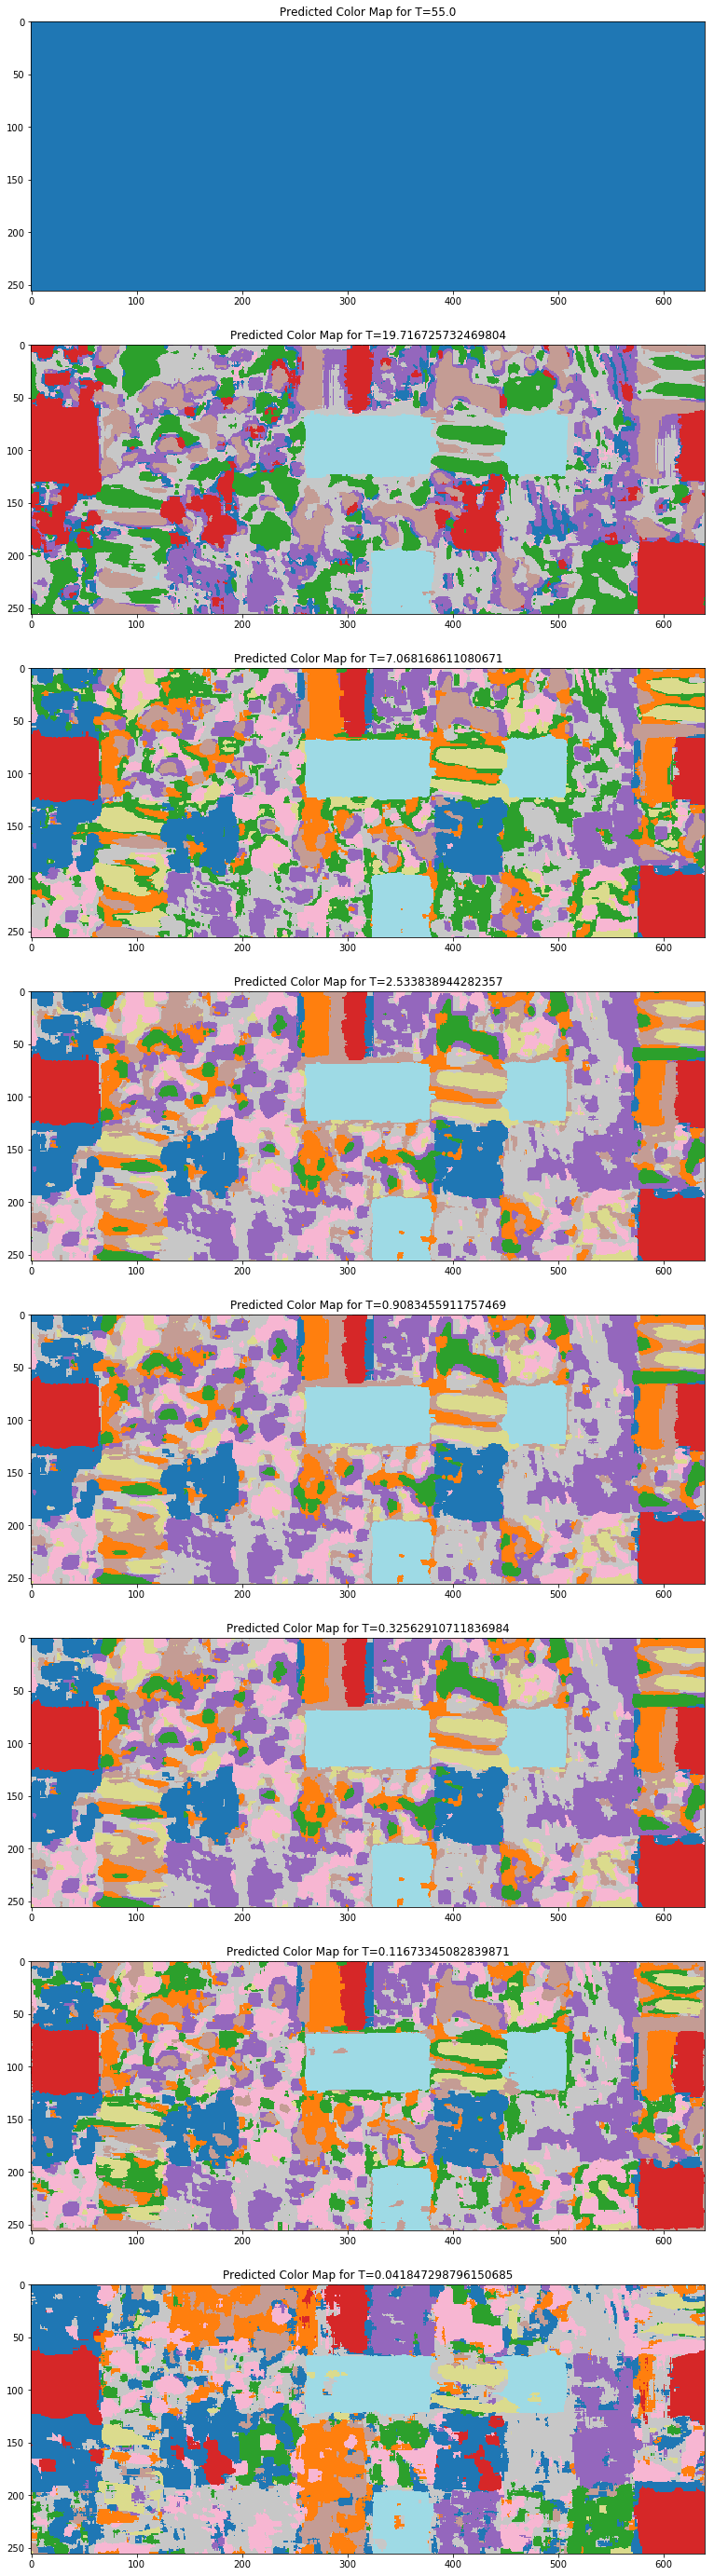

In [10]:
# Clustering at different temperatures
def predict_outside(centroids, X, temperature):
    interval = 256 / HC.n_bins  # For quantizing original image colors to given bins
    print(interval)
    height = X.shape[0]
    width = X.shape[1]
    n_objects = X.shape[0] * X.shape[1]
    X_padded = cv2.copyMakeBorder(X, int((HC.window_size - 1) / 2), int((HC.window_size - 1) / 2),
                                          int((HC.window_size - 1) / 2), int((HC.window_size - 1) / 2),
                                          cv2.BORDER_REPLICATE)
    X_padded *= 255.0 / X_padded.max()  # Scale image to 0,255

    n_x_y = np.zeros((n_objects, HC.n_bins))  # 2D array of local color counts of 64 bins for each pixel site(object)
    value = int((HC.window_size - 1) / 2)
    index = 0
    for i in range(value, height + value):
        for j in range(value, width + value):
            local_arr = X_padded[i - value:i + value + 1, j - value:j + value + 1]
            local_arr = np.floor_divide(local_arr, interval)
            # print((np.histogram(local_arr.flatten(), bins=np.arange(self.n_bins+1))))
            # print(local_arr)
            n_x_y[index, :] = (np.histogram(local_arr.flatten(), bins=np.arange(HC.n_bins + 1)))[0]
            index = index + 1

    n_x = np.sum(n_x_y, axis=1)

    p_y_given_x = n_x_y / n_x[:, None]  # n_objects x n_bins, emprical distr.
    distance_mat = HC.get_distance(p_y_given_x, centroids)
    probs = HC._calculate_cluster_probs(distance_mat, n_x, temperature)
    C_temp = np.argmax(probs, axis = 1)
    C = C_temp.reshape(X.shape[0], X.shape[1])
    
    return C
    
patch_shape=(32,32)

perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)
label_map_downsampled = rescale(label_map, 0.25, anti_aliasing=False)

perm_texture_downsampled = np.ones(texture_downsampled.shape)
perm_label_map_downsampled = np.ones(texture_downsampled.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture_downsampled[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture_downsampled[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map_downsampled[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map_downsampled[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

#plt.imshow(perm_texture_downsampled)
#plt.title("Permuted Textures")
#plt.figure()
#plt.imshow(perm_label_map_downsampled, cmap="tab20")
#plt.title("Permuted Labels")
#plt.show()

#print(texture_downsampled.shape)
#perm_texture_downsampled = rescale(perm_texture, 0.25, anti_aliasing=False)
predicted_perm_label_map = hungarian_algorithm(HC.predict(perm_texture),perm_label_map)#TRY PERM_TEXTURE INSTEAD
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.title('Predicted Label Map Upon Fitting')

fig, ax = plt.subplots(8,1, figsize=(20, 50))
i=0
counter = 0
while i <= len(HC.centroids_list):
    if counter == 7:
        temp_C = hungarian_algorithm(HC.predict(perm_texture),perm_label_map)
        ax[counter].set_title('Predicted Color Map for T='+str(55*(0.95**i)))
        ax[counter].imshow(hungarian_algorithm(temp_C,perm_label_map), cmap="tab20")#So that clusters are matched and thus the histograms are matching
    else:
        temp_C = predict_outside(HC.centroids_list[i],perm_texture,55*(0.95**i))
        ax[counter].set_title('Predicted Color Map for T='+str(55*(0.95**i)))
        ax[counter].imshow(hungarian_algorithm(temp_C,perm_label_map), cmap="tab20")#So that clusters are matched and thus the histograms are matching
    i = i + 20
    counter = counter + 1
    



In this part, we have plotted the DA implementation of HC following a MAP principle. For reasons regarding the computational time, the window_size, which we have previously seen to be crucial for the performance of the algorithm was limited. This stems from the fact that the DA approach requires the calculation of KL divergence for each image site (pixel) at each EM iteration which of course imposes a heavy computational complexity. We also notice that for the DA algorithm to clearly seperate and identify all 10 clusters we need 9 phase transitions to happen all of which probably might not have teken place in the pre-specified(167) number of iterations. Moreover, as opposed to kmeans - DA approach, there is no tool for us to pre determine the critical tempuratures so that we dynamically introduce new centroids when necessary in a mass constrained fashaion. Thus, we have to emprically choose a minimum tempurature beforehand with a good emprical guess and hope that as many critical tempuratures occur as possible until minimum tempurature is reached. Nevertheless, we observe that the end result for predicting the label map via hard classification (i.e, hard ranking of cluster probabilities of $p_{i,c(i)}$) upon fitting yields satisfactory results. We notice that, the DA approach already is very close to clearly identifying 6 clusters: the blue, red, gray, orange, purple and turqoise labelled clusters which is more clearly visible in the 1st figure above titled 'Predicted Label Map Upon Fitting'. As we can see, the other centroids are still quite mingled as the critical tempurature for the splitting of these centroids probabily hadn't taken place yet such that they are still close in the probability simplex up to some noise factor, causing the patches belonging to pink, yellow, brown or green clusters are almost randomly and non-informatively assigned to any of these 4 clusters. This behaviour can also be better seen in the confusion matrix provided below which is very similar to the confusion matrix that emerges for the MAP approach with the default parameters: n_bins = 64, window_size = 7. We also inspect the label map prediction quality throughout each tempurature. We observe that initially, analogous to the kmeans_DA case, all the centroids collapse to the single centroid which is the sample mean of $p(y|x)$'s over all image sites $x$. Therefore, in the begginging of the 1st iteration, we obsreve that all the pixels are naturally assigned to this one cluster which is arbitrarily labelled blue. In the later iterations, as more and more critical tempuratures are encountered, we observe that therer are new centroids emerging away from the degenerate centroids on the probability simplex snd so the algorithm is able to better identify and single out these transitioned centroids. For instance, in the 2nd subplots, we clearly have at least one phase transition where the purple and the red centroids are distinguishable. With succeeding iterations, new phse transitions and corresponding EM updates occur and the algorithm starts unambigiously identifying new centroids correctly, ultimately reaching our prediction at the end. Thus, we observe that in compliance with the core idea of DA optimization, the algorithm evolves from low resolution solutions where non-informative and highly random posteriors are put on the solution space (space of all cluster assignments), into more refined and high resolution solutions where more and more centroids are distinguished and labelles accordingly by successively lowering the tempurature. Hence, from this behaviour, we are guaranteed to have improved performance which perhaps even perfectly matches the ground truth label map, if we continue the training for further iterations, allowing more critical tempuratures and increasing the solution quality. Moreover, in the limit $T\rightarrow\infty$, the DA algorithm upon finding all the centroids starts acting like regular HC, in which case all pixels are naturally assigned to their closest centroid in the probability simplex via KL divergence measure. As a final remark, although for this toy example DA doesn't seem to have many advantages over HC in terms of clustering performance, this annealing schedule often greatly improves the performance on rather difficult clustering tasks where the image setting is more complicated or sgemented patches do not have similar or uniform color dsitributions etc.

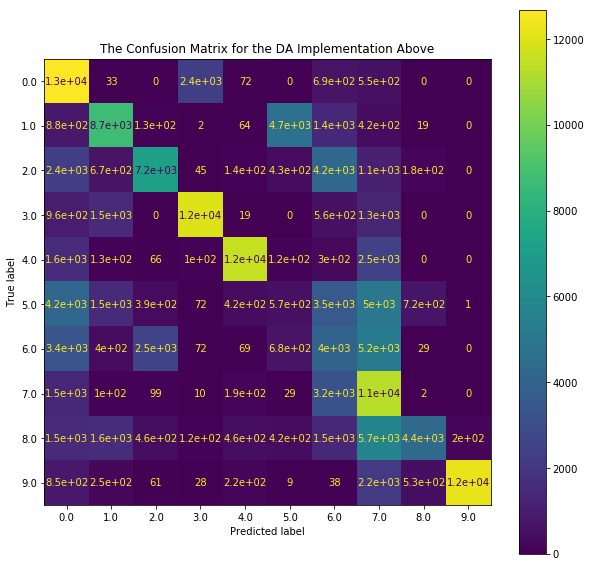

In [13]:
confusion_matrix_HC_DA = confusion_matrix(perm_label_map.flatten(), hungarian_algorithm(predicted_perm_label_map, perm_label_map).flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_HC_DA, display_labels=np.unique(perm_label_map))
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('The Confusion Matrix for the DA Implementation Above')
disp.plot(ax=ax)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.

1)In the MAP implementation of DA, the unidorm prior $P(c)$ was assumed and one step Alternating Minimization Scheme was followed as mentioned in the paper for convenience.

2)Due to the heavy computational cost resulting from large image size etc, (as described in Section 6.0 description), the DA algorithm indeed takes a while to converge, but again, as argued earlier, performs as desired until the preset minimum tempurature and provides a good proof of concept. Likewise, in the paper, alternative methods that follow DA principle but improve its performance such as Multi Scale Annealing are discussed to tackle this expected issue.